In [ ]:
#tujuan : Memprediksi data di waktu mendatang, mengisi data kosong, memprediksi pola data
#metrics: Mean squared error, Mean absolute error
#model.compile(loss=tf.keras.losses.Huber(),
              #optimizer=optimizer,
              #metrics=["mae"])

In [ ]:
#model.compile(loss=tf.keras.losses.Huber(),
#             optimizer=optimizer,
#              metrics=["mae"])

In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Dense, LSTM
from google.colab import files
uploaded = files.upload()

Saving testset.csv to testset.csv


In [ ]:
dweather = pd.read_csv('testset.csv') #header=None
dweather.head(6)

,datetime_utc,_conds,_dewptm,_fog,_hail,_heatindexm,_hum,_precipm,_pressurem,_rain,_snow,_tempm,_thunder,_tornado,_vism,_wdird,_wdire,_wgustm,_windchillm,_wspdm
0,19961101-11:00,Smoke,9.0,0,0,NaN,27.0,NaN,1010.0,0,0,30.0,0,0,5.0,280.0,West,NaN,NaN,7.4
1,19961101-12:00,Smoke,10.0,0,0,NaN,32.0,NaN,-9999.0,0,0,28.0,0,0,NaN,0.0,North,NaN,NaN,NaN
2,19961101-13:00,Smoke,11.0,0,0,NaN,44.0,NaN,-9999.0,0,0,24.0,0,0,NaN,0.0,North,NaN,NaN,NaN
3,19961101-14:00,Smoke,10.0,0,0,NaN,41.0,NaN,1010.0,0,0,24.0,0,0,2.0,0.0,North,NaN,NaN,NaN
4,19961101-16:00,Smoke,11.0,0,0,NaN,47.0,NaN,1011.0,0,0,23.0,0,0,1.2,0.0,North,NaN,NaN,0.0
5,19961101-17:00,Smoke,12.0,0,0,NaN,56.0,NaN,1011.0,0,0,21.0,0,0,NaN,0.0,North,NaN,NaN,NaN


In [ ]:
dweather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100990 entries, 0 to 100989
Data columns (total 20 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   datetime_utc  100990 non-null  object 
 1    _conds       100918 non-null  object 
 2    _dewptm      100369 non-null  float64
 3    _fog         100990 non-null  int64  
 4    _hail        100990 non-null  int64  
 5    _heatindexm  29155 non-null   float64
 6    _hum         100233 non-null  float64
 7    _precipm     0 non-null       float64
 8    _pressurem   100758 non-null  float64
 9    _rain        100990 non-null  int64  
 10   _snow        100990 non-null  int64  
 11   _tempm       100317 non-null  float64
 12   _thunder     100990 non-null  int64  
 13   _tornado     100990 non-null  int64  
 14   _vism        96562 non-null   float64
 15   _wdird       86235 non-null   float64
 16   _wdire       86235 non-null   object 
 17   _wgustm      1072 non-null    float64
 18   _wi

In [ ]:
dweather.shape

(100990, 20)

In [ ]:
#null info sum
dweather.isnull().sum()

datetime_utc         0
 _conds             72
 _dewptm           621
 _fog                0
 _hail               0
 _heatindexm     71835
 _hum              757
 _precipm       100990
 _pressurem        232
 _rain               0
 _snow               0
 _tempm            673
 _thunder            0
 _tornado            0
 _vism            4428
 _wdird          14755
 _wdire          14755
 _wgustm         99918
 _windchillm    100411
 _wspdm           2358
dtype: int64

In [ ]:
#fill null
dweather['datetime_utc']=pd.to_datetime(dweather['datetime_utc'])
dweather['datetime_utc'].head()
dweather[' _tempm'].fillna(dweather[' _tempm'].mean(), inplace=True) # we will fill the null row
dweather = dweather[['datetime_utc',' _tempm' ]]
dweather.head(6)

,datetime_utc,_tempm
0,1996-11-01 11:00:00,30.0
1,1996-11-01 12:00:00,28.0
2,1996-11-01 13:00:00,24.0
3,1996-11-01 14:00:00,24.0
4,1996-11-01 16:00:00,23.0
5,1996-11-01 17:00:00,21.0


In [ ]:
dnew=dweather[['datetime_utc',' _tempm']].copy()
dnew['just_date'] = dnew['datetime_utc'].dt.date

delhi_data=dnew.drop('datetime_utc',axis=1)
delhi_data.set_index('just_date', inplace= True)
delhi_data.head()

,_tempm
just_date,
1996-11-01,30.0
1996-11-01,28.0
1996-11-01,24.0
1996-11-01,24.0
1996-11-01,23.0


In [ ]:
# get data values
date = dweather['datetime_utc'].values
temp = dweather[' _tempm'].values

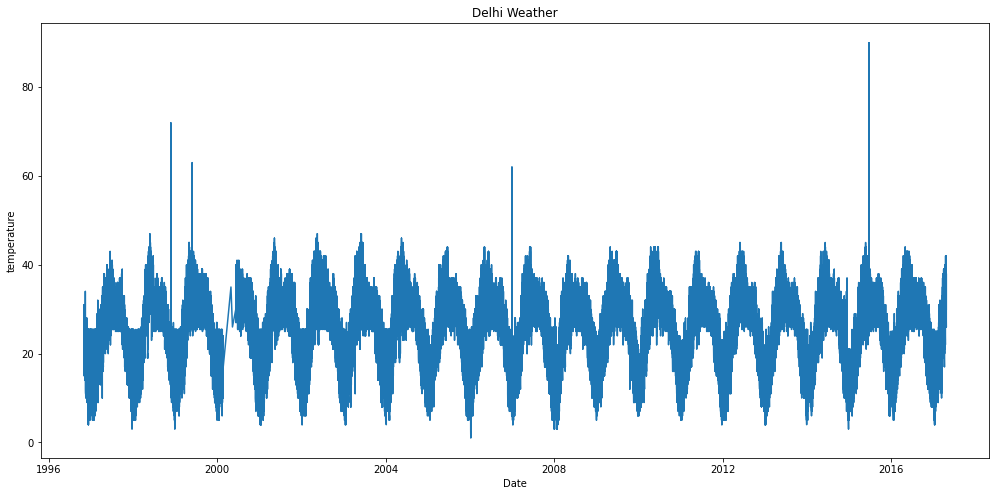

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(17,8))
plt.plot(delhi_data)
plt.title('Delhi Weather')
plt.xlabel('Date')
plt.ylabel('temperature')
plt.show()

In [ ]:
#Mengubah format menjadi numpy, dan mengembalikan label dan feature dari dataset dalam bentuk batch
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:

#make sure the amount rows
dweather

,datetime_utc,_tempm
0,1996-11-01 11:00:00,30.0
1,1996-11-01 12:00:00,28.0
2,1996-11-01 13:00:00,24.0
3,1996-11-01 14:00:00,24.0
4,1996-11-01 16:00:00,23.0
...,...,...
100985,2017-04-24 06:00:00,34.0
100986,2017-04-24 09:00:00,38.0
100987,2017-04-24 12:00:00,36.0
100988,2017-04-24 15:00:00,32.0


In [ ]:
#train_test split
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(temp, date, test_size = 0.2, random_state = 0 , shuffle=False)
print(len(x_train), len(x_test))

80792 20198


In [ ]:
from keras.layers import Dense, LSTM

data_x_train = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=5000)
data_x_test = windowed_dataset(x_test, window_size=60, batch_size=100, shuffle_buffer=5000)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [ ]:
min = dweather[' _tempm'].min()
print('Min Value : ')
print(min)

Min Value : 
1.0


In [ ]:
max = dweather[' _tempm'].max()
print('Max Value : ')
print(max)

Max Value : 
90.0


In [ ]:
x = (90.0 - 1.0) * (10/100)
print(x)

8.9


In [ ]:
#Callback opt
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')< x):
      self.model.stop_training = True
      print("\nMAE of the model < 0.1 of data scale")
callbacks = myCallback()

In [ ]:
tf.keras.backend.set_floatx('float64')
history = model.fit(data_x_train ,epochs=500, validation_data=data_x_test, callbacks=[callbacks])

Epoch 1/500
    808/Unknown - 305s 376ms/step - loss: 5.7717 - mae: 6.2517
MAE of the model < 0.1 of data scale
808/808 [==============================] - 346s 427ms/step - loss: 5.7717 - mae: 6.2517 - val_loss: 5.5818 - val_mae: 6.0619
